In [1]:
import json 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from statsmodels.graphics.tsaplots import plot_acf
from itertools import cycle, islice
%matplotlib inline

## Part 1 ‑ Exploratory data analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular 
geographic location. Aggregate these login counts based on 15-minute time intervals, and 
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

### Login Data

In [2]:
login_df = pd.read_json('logins.json')

In [3]:
# First 5 rows in dataframe
login_df.head()
# Timestatmps don't appear to be in order

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
# Sorting timestamps in chronological order
login_df = login_df.sort_values('login_time')

In [5]:
# First 5 rows in dataframe
login_df.tail()
# It looks like these timestamps may be incorrect
# In 1970 there were no rideshare apps
# Also the first data point seems to be from the 1st Unix Epoch
# Also there is only about 3.5 months of data

,login_time
93136,1970-04-13 18:48:52
93137,1970-04-13 18:50:19
93139,1970-04-13 18:54:02
93141,1970-04-13 18:54:23
93140,1970-04-13 18:57:38


In [6]:
login_df.info()
# Login times are in the form of datetime objects and there are no missing values

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93142 entries, 6 to 93140
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 1.4 MB


In [7]:
# Setting index to be login_time
login_df.set_index('login_time', inplace=True)

In [8]:
# Aggregating login counts by 15 minutes
login_15min = login_df
login_15min['count'] = 0
login_15min = login_df.resample('15min').count()

In [9]:
# Now we have login counts on 15 minute intervals
login_15min.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


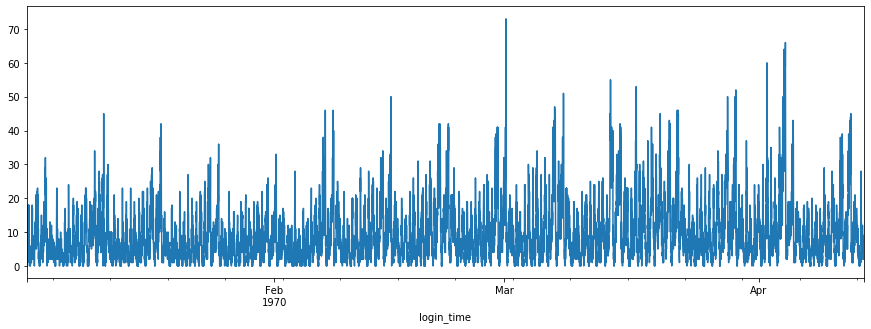

In [10]:
# Plotting time series of login counts
_ = login_15min['count'].plot(figsize=(15,5))
_ = plt.show()
# There appears to be some cyclic pattern in the time-series data

In [11]:
# Creating new df to show cummulative logins for each day
df = pd.DataFrame(login_15min)
df['day_of_week'] = df.index.map(lambda x: x.dayofweek)

In [12]:
day_of_week = df.groupby('day_of_week').mean()
day_of_week.index = ['Mon', 'Tues', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']

In [13]:
day_of_week

,count
Mon,6.213380
Tues,6.895833
Wed,7.692708
Thur,8.794118
Fri,10.561111
Sat,13.456250
Sun,12.615972


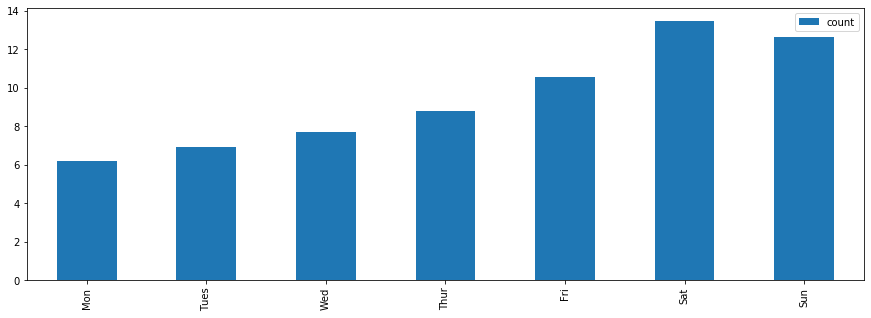

In [14]:
day_of_week.plot(kind='bar', figsize=(15,5))
# It looks like there's an increasing trend throughout the week with a drop on Sunday

In [15]:
df['hour'] = df.index.map(lambda x: x.hour)
hours = df

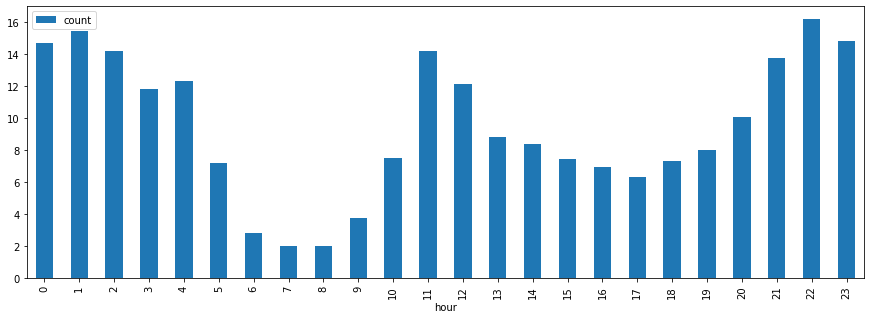

In [16]:
hours = pd.DataFrame(df.groupby('hour').mean()['count'])
hours.plot(kind='bar', figsize=(15,5))
# It looks like there are peaks every 12 hours

## Part 2 ‑ Experiment and metrics design

### 1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
- I would measure the amount of time a driver passes the toll per day. Since the tolls will be re-imbursed there has to be a records of each time a driver passes the toll. It these numbers for each driver, then the experiment would be a success. Another option could be to track the coordinates of each driver. By doing this you could precisely measure the amount of time each driver spends in a particular city.

### 2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

- **a. how you will implement the experiment**:
    I would create a control group of drivers that do not get reimbursed for tolls. The other group of drivers will get reimbursed for their tolls. This would eliminate any external factors and it would be easier to prove that reimbursement alone encourages driver partners to serve both cities. <br/>

- **b. what statistical test(s) you will conduct to verify the significance of the observation**: This could fall under an A/B testing experiment, but keeping one group the same as the controlled group. 

- **c. how you would interpret the results and provide recommendations to the city operations team along with any caveats.**: It would be very simple, I would look at the distributions of the the number of times drivers in both groups went through the toll booths

## Part 3 ‑ Predictive modeling

### Trip Data

In [17]:
import datetime as dt

In [18]:
trip_df = pd.read_json('ultimate_data_challenge.json')

In [19]:
trip_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [20]:
trip_df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [21]:
trip_df.info()
# There are some missing values in the dataset
# I will simply drop the rows with missing data, which will still leave ~80% of the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [22]:
trip_df = trip_df.dropna()

In [23]:
# Converting dates to datetime objects
trip_df['signup_date'] = pd.to_datetime(trip_df['signup_date'])
trip_df['last_trip_date'] = pd.to_datetime(trip_df['last_trip_date'])

In [24]:
# Creating feature for retention in days
trip_df['retention'] = (trip_df['last_trip_date'] - trip_df['signup_date']).dt.days.astype('int16')

In [25]:
# Creating binary feature for rider retention (ie: >30 days)
trip_df['target'] = trip_df['retention'].apply(lambda x: 1 if x>=30 else 0)

In [26]:
# Getting counts of retention
trip_df.target.value_counts()

# It looks like this sample is particularly inbalanced

1    31967
0     9478
Name: target, dtype: int64

In [30]:
count_dict = trip_df.target.value_counts().to_dict()
count_dict

{1: 31967, 0: 9478}

In [32]:
from sklearn.utils import shuffle, resample
# Bootstrapping targets of 0
not_retained = trip_df[trip_df['target'] == 0]
not_retained = resample(not_retained, 
                  replace=True, # Sample with replacement
                  n_samples=count_dict[1], # Want to have same number of postiive reviews
                  random_state=123)

In [34]:
# Combinbing dfs back together
retained = trip_df[trip_df['target'] == 1]
bs_df = pd.concat([retained, not_retained])

In [36]:
bs_df.target.value_counts()

1    31967
0    31967
Name: target, dtype: int64

In [37]:
# Shuffling balanced dataframe
df_shuffled = shuffle(bs_df)

### Modeling

In [58]:
# Importing ML Libraries
from sklearn.model_selection import train_test_split
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve

In [44]:
# Getting features and target
features = df_shuffled.drop(['city', 'last_trip_date', 'phone', 'signup_date', 'retention', 'target'], axis=1)
target = df_shuffled['target']

In [45]:
#separate training and testing data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=123)

#### Logistic Regression Classifier

In [56]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=20)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

C:\Users\ZachP\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [57]:
#Checking to see how well the model worked

print('R-squared score: ',model.score(X_test, y_test))
print('Confusion Matrix: ')
print(confusion_matrix(y_test, y_pred))
print()
print(classification_report(y_test, y_pred))

R-squared score:  0.5705012903730351
Confusion Matrix: 
[[4082 2310]
 [3182 3213]]

              precision    recall  f1-score   support

           0       0.56      0.64      0.60      6392
           1       0.58      0.50      0.54      6395

    accuracy                           0.57     12787
   macro avg       0.57      0.57      0.57     12787
weighted avg       0.57      0.57      0.57     12787



#### Support Vector Machine

In [49]:
from sklearn.svm import LinearSVC

svc = LinearSVC(random_state=20)
svc.fit(X_train, y_train)
y_pred2 = svc.predict(X_test)

C:\Users\ZachP\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [50]:
#Checking to see how well the model worked

print('R-squared score: ',svc.score(X_test, y_test))
print('Confusion Matrix: ')
print(confusion_matrix(y_test, y_pred2))
print()
print(classification_report(y_test, y_pred2))

R-squared score:  0.5812152967857981
Confusion Matrix: 
[[1705 4687]
 [ 668 5727]]

              precision    recall  f1-score   support

           0       0.72      0.27      0.39      6392
           1       0.55      0.90      0.68      6395

    accuracy                           0.58     12787
   macro avg       0.63      0.58      0.54     12787
weighted avg       0.63      0.58      0.54     12787



#### Random Forest

In [51]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(max_depth=5, random_state=20)
rfc.fit(X_train, y_train)
y_pred3 = rfc.predict(X_test)

In [52]:
print('R-squared score: ',rfc.score(X_test, y_test))
print('Confusion Matrix: ')
print(confusion_matrix(y_test, y_pred3))
print()
print(classification_report(y_test, y_pred3))

R-squared score:  0.8645499335262375
Confusion Matrix: 
[[5801  591]
 [1141 5254]]

              precision    recall  f1-score   support

           0       0.84      0.91      0.87      6392
           1       0.90      0.82      0.86      6395

    accuracy                           0.86     12787
   macro avg       0.87      0.86      0.86     12787
weighted avg       0.87      0.86      0.86     12787



#### KNN

In [53]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)
y_pred4 = knn.predict(X_test)

In [54]:
#Checking to see how well the model worked

print('R-squared score: ',knn.score(X_test, y_test))
print('Confusion Matrix: ')
print(confusion_matrix(y_test, y_pred4))
print()
print(classification_report(y_test, y_pred4))

R-squared score:  0.9357159615234222
Confusion Matrix: 
[[6354   38]
 [ 784 5611]]

              precision    recall  f1-score   support

           0       0.89      0.99      0.94      6392
           1       0.99      0.88      0.93      6395

    accuracy                           0.94     12787
   macro avg       0.94      0.94      0.94     12787
weighted avg       0.94      0.94      0.94     12787



Based on the results, it appears that the KNN classifier performed the best here. It had the best accuracy, precision/recall and correpsonding F1-Score compared to the rest of the classifiers.